# Lecture 5. Topic Models

Natural Language Processing for Law and Social Science<br>
Elliott Ash, ETH Zurich

In [3]:
# set random seed
import numpy as np
np.random.seed(4)
import seaborn as sns
sns.set_theme()

In [2]:
# Setup
import warnings; warnings.simplefilter('ignore')
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
df = pd.read_pickle('sc_cases_cleaned.pkl',compression='gzip')

In [8]:
from gensim.utils import simple_preprocess
text0 = ' '.join(simple_preprocess(df['opinion_text'][0]))
text1 = ' '.join(simple_preprocess(df['opinion_text'][1]))

text1[:1000]

'justice stevens delivered the opinion of the court in most of the united states not including california the minimum price paid to dairy farmers producing raw milk is regulated pursuant to federal marketing orders those orders guarantee uniform price for the producers but through pooling mechanisms require the processors of different classes of dairy products to pay different prices thus for example processors of fluid milk pay premium price part of which goes into an equalization pool that provides partial subsidy for cheese manufacturers who pay net price that is lower than the farmers receive seewest lynn creamery inc healy ed ct the california legislature has adopted similar program to regulate the minimum prices paid by california processors to california producers in the cases before us today out of state producers are challenging the of amendment to that program they present us with two questions whether of the federal agriculture improvement and reform act of stat usc uscs exe

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=0.01, # at min 1% of docs
                        max_df=.9,  
                        max_features=500,
                        stop_words='english',
                        ngram_range=(1,3))
X = vectorizer.fit_transform(df['preprocessed'])
words = vectorizer.get_feature_names()

In [11]:
X = X.todense()
X = X / X.sum(axis=1)
features = []
for i, word in enumerate(words):
    column = X[:,i]
    df['x_'+word] = np.ravel(column)
    features.append('x_'+word)
df.head()

case_name opinion_type  \
0                ERICK CORNELL CLAY v. UNITED STATES     majority   
1  HILLSIDE DAIRY INC., A&A DAIRY, L&S DAIRY, AND...     majority   
2    CHARLES RUSSELL RHINES v. DOUGLAS WEBER, WARDEN     majority   
4        STATE OF ALASKA v. UNITED STATES OF AMERICA     majority   
5  REGINALD A. WILKINSON, DIRECTOR, OHIO DEPARTME...     majority   

  date_standard authorship  x_republican  \
0    2003-03-04   GINSBURG           0.0   
1    2003-06-09    STEVENS           1.0   
2    2005-03-30   O'CONNOR           1.0   
4    2005-06-06    KENNEDY           1.0   
5    2005-06-13    KENNEDY           1.0   

                                          maj_judges  \
0  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
1  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
2  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
4  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   
5  ['BREYER, STEPHEN', 'GINSBURG, RUTH', 'KENNEDY...   

                                      dissent_judges  topic_id  cite_count  \
0                                                 []       1.0      2926.0   
1                               ['THOMAS, CLARENCE']       8.0       117.0   
2                                                 []       1.0     23364.0   
4  ['REHNQUIST, WILLIAM', 'SCALIA, ANTONIN', 'THO...      10.0        84.0   
5                                                 []       4.0      4230.0   

                                        opinion_text  ...    x_view  x_violat  \
0  JUSTICE GINSBURG delivered the opinion of the ...  ...  0.001486  0.002972   
1  Justice Stevens delivered the opinion of the C...  ...  0.000000  0.004107   
2  Justice O'Connor delivered the opinion of the ...  ...  0.000000  0.001464   
4  Justice Kennedy delivered the opinion of the C...  ...  0.008020  0.000000   
5  Justice Kennedy delivered the opinion of the C...  ...  0.000781  0.004684   

  x_vote  x_warrant   x_water     x_way     x_wit    x_word    x_work  \
0    0.0   0.001486  0.000000  0.002972  0.000000  0.011887  0.000000   
1    0.0   0.000000  0.000000  0.000000  0.000000  0.002053  0.000000   
2    0.0   0.000000  0.000000  0.001464  0.000000  0.000000  0.000000   
4    0.0   0.000000  0.063158  0.002506  0.000000  0.000501  0.000501   
5    0.0   0.000000  0.000000  0.000000  0.006245  0.000781  0.000781   

     x_year  
0  0.004458  
1  0.000000  
2  0.001464  
4  0.002005  
5  0.003123  

[5 rows x 513 columns]

## Principal Component Analysis

How it works (more info [here](https://towardsdatascience.com/principal-component-analysis-for-dimensionality-reduction-115a3d157bad)):

1. Construct the covariance matrix of the standardized features
2. Get the eigenvectors and eigenvalues
3. Select k eigenvectors which correspond to the k largest eigenvalues, where k is the dimensionality of the new feature subspace (the number of principal components)
4. Construct the projection matrix from these k eigenvectors and transform the features using this matrix

In [15]:
#%% Principal Components
y = (df['log_cite_count']>df.log_cite_count.mean()).astype('int')
X = df[features]

from sklearn.decomposition import PCA
pca = PCA(n_components=3,svd_solver='randomized')
Xpca = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.05998923, 0.04364894, 0.03286098])

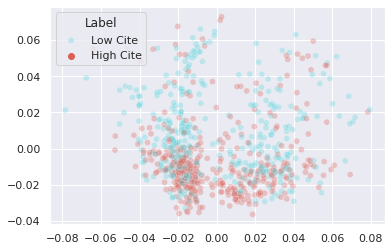

In [18]:
plot = sns.scatterplot(
    x=Xpca[:,0], y=Xpca[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

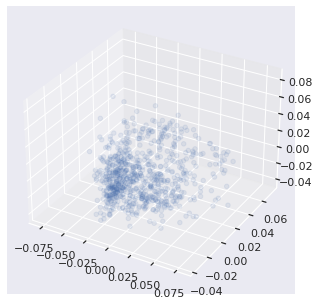

In [19]:
#%% PCA 3D Viz
from mpl_toolkits.mplot3d import Axes3D
Axes3D(plt.figure()).scatter(Xpca[:,0],Xpca[:,1], Xpca[:,2], alpha=.1)
plt.show()

In [20]:
#%% make components to explain 95% of variance
pca = PCA(n_components=.95)
X95 = pca.fit_transform(X)
pca.n_components_

234

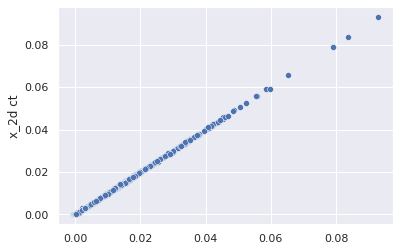

In [40]:
#%% PCA Inverse Transform
Xrestore = pca.inverse_transform(X95)
plot = sns.scatterplot(x=Xrestore[:,0],y=X.iloc[:, 0])

In [14]:
#%% Incremental PCA
X_mm = np.memmap('X.pkl',shape=(32567, 525))

from sklearn.decomposition import IncrementalPCA
inc_pca = IncrementalPCA(n_components=100, batch_size=1000)
inc_pca.fit(X_mm)

IncrementalPCA(batch_size=1000, n_components=100)

In [41]:
#%% PC Regression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
Y = df['log_cite_count']
lin_reg = LinearRegression()
scores = cross_val_score(lin_reg,
                         X95[:,:10],
                         Y) 
scores.mean()

0.1703975957217727

#### [MDS](https://towardsdatascience.com/mds-multidimensional-scaling-smart-way-to-reduce-dimensionality-in-python-7c126984e60b), [Isomap](https://towardsdatascience.com/isomap-embedding-an-awesome-approach-to-non-linear-dimensionality-reduction-fc7efbca47a0), [T-SNE](https://towardsdatascience.com/an-introduction-to-t-sne-with-python-example-5a3a293108d1)


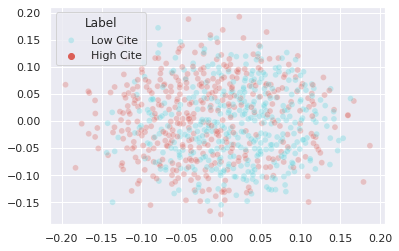

In [46]:
#%% MDS, Isomap, and T-SNE
from sklearn.manifold import MDS, Isomap, TSNE
mds = MDS(n_components=2)
Xmds = mds.fit_transform(X)
plot = sns.scatterplot(
    x=Xmds[:,0], y=Xmds[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

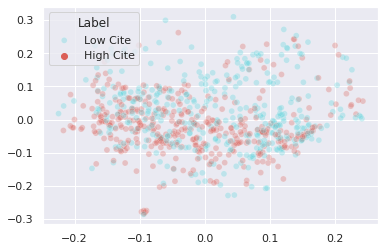

In [45]:
#%% Isomap
iso = Isomap(n_components=2)
Xiso = iso.fit_transform(X)
plot = sns.scatterplot(
    x=Xiso[:,0], y=Xiso[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

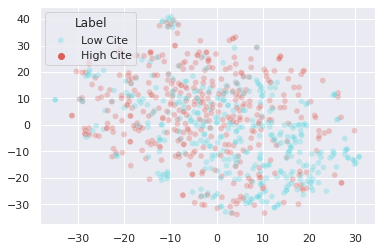

In [44]:
#%% t-SNE
tsne = TSNE(n_components=2, n_iter=500, perplexity=25)
Xtsne = tsne.fit_transform(X)
plot = sns.scatterplot(
    x=Xtsne[:,0], y=Xtsne[:,1],
    hue=y,
    palette=sns.color_palette("hls", 2),
    legend="full",
    alpha=0.3
)

plt.legend(title='Label', loc='upper left', labels=["Low Cite", "High Cite"])
plt.show(plot)

# Latent Dirichlet Allocation

For further reference see the material from topic [modeling with gensim](https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/).

In [47]:
# clean document
from gensim.utils import simple_preprocess
import spacy
from spacy.tokenizer import Tokenizer
from tqdm import tqdm as tq
nlp = spacy.load('en_core_web_sm')
# this is faster and we don't need the whole grammatical parse analysis

def tokenize(x, nlp):
    # lemmatize and lowercase without stopwords, punctuation and numbers
    return [w.lemma_.lower() for w in nlp(x) if not w.is_stop and not w.is_punct and not w.is_digit and len(w) > 2]

# split into paragraphs
doc_clean = []
for doc in tq(df['opinion_text'][:100]):
    # split by paragraph
    for paragraph in doc.split("\n\n"):
        doc_clean.append(tokenize(paragraph, nlp))

# randomize document order
from random import shuffle
shuffle(doc_clean)

# creating the term dictionary
from gensim import corpora
dictionary = corpora.Dictionary(doc_clean)
# filter extremes, drop all words appearing in less than 10 paragraphs and all words appearing in at least every third paragraph
dictionary.filter_extremes(no_below=10, no_above=0.33, keep_n=1000)
print (len(dictionary))

100%|██████████| 100/100 [01:19<00:00,  1.25it/s]


1000


In [48]:
# creating the document-term matrix
doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]

# train LDA with 10 topics and print
from gensim.models.ldamodel import LdaModel
lda = LdaModel(doc_term_matrix, num_topics=10, 
               id2word = dictionary, passes=3)
lda.show_topics(formatted=False)

[(0,
  [('claim', 0.042550795),
   ('petition', 0.028987562),
   ('rule', 0.022748651),
   ('judgment', 0.01745944),
   ('federal', 0.017428692),
   ('file', 0.017144578),
   ('district', 0.015081247),
   ('state', 0.015002854),
   ('ineffective', 0.014036038),
   ('time', 0.0139844)]),
 (1,
  [('trial', 0.0179856),
   ('jury', 0.017951285),
   ('counsel', 0.01634255),
   ('id.', 0.015893258),
   ('evidence', 0.012433088),
   ('judge', 0.012082959),
   ('search', 0.011335298),
   ('u.s.', 0.011095748),
   ('case', 0.0110052675),
   ('petitioner', 0.01068331)]),
 (2,
  [('state', 0.047693662),
   ('u.s.', 0.033361595),
   ('federal', 0.02735906),
   ('claim', 0.017252047),
   ('law', 0.01567632),
   ('case', 0.013706578),
   ('application', 0.012140881),
   ('judgment', 0.011881167),
   ('rule', 0.011816711),
   ('epa', 0.011324733)]),
 (3,
  [('states', 0.049561877),
   ('united', 0.04112275),
   ('f.3d', 0.041022453),
   ('plan', 0.020819515),
   ('u.s.', 0.018961802),
   ('employee',

In [49]:
# to get the topic proportions for a document, use
# the corresponding row from the document-term matrix.
lda[doc_term_matrix[1]]

[(3, 0.24839158), (4, 0.47554907), (5, 0.13923109), (9, 0.116820954)]

In [50]:
# or, for all documents
[lda[d] for d in doc_term_matrix]

[[(0, 0.020000475),
  (1, 0.020000825),
  (2, 0.020000976),
  (3, 0.020000618),
  (4, 0.020001443),
  (5, 0.020000605),
  (6, 0.020000583),
  (7, 0.020001445),
  (8, 0.81999224),
  (9, 0.02000081)],
 [(3, 0.24842444), (4, 0.47574097), (5, 0.13909008), (9, 0.11673721)],
 [(0, 0.1),
  (1, 0.1),
  (2, 0.1),
  (3, 0.1),
  (4, 0.1),
  (5, 0.1),
  (6, 0.1),
  (7, 0.1),
  (8, 0.1),
  (9, 0.1)],
 [(0, 0.1),
  (1, 0.1),
  (2, 0.1),
  (3, 0.1),
  (4, 0.1),
  (5, 0.1),
  (6, 0.1),
  (7, 0.1),
  (8, 0.1),
  (9, 0.1)],
 [(2, 0.19935381), (5, 0.52180666), (9, 0.25382867)],
 [(1, 0.28905812), (4, 0.482508), (5, 0.13397834), (9, 0.08195214)],
 [(4, 0.22753143), (5, 0.16236416), (8, 0.050469894), (9, 0.5402743)],
 [(1, 0.2708003), (3, 0.22214149), (6, 0.25332445), (7, 0.24632378)],
 [(5, 0.65250045), (8, 0.33082542)],
 [(0, 0.08279339), (7, 0.090781905), (9, 0.80454224)],
 [(0, 0.63179743), (5, 0.28767595), (8, 0.059932165)],
 [(5, 0.10341652), (8, 0.88481474)],
 [(6, 0.9816251)],
 [(0, 0.094471894), (

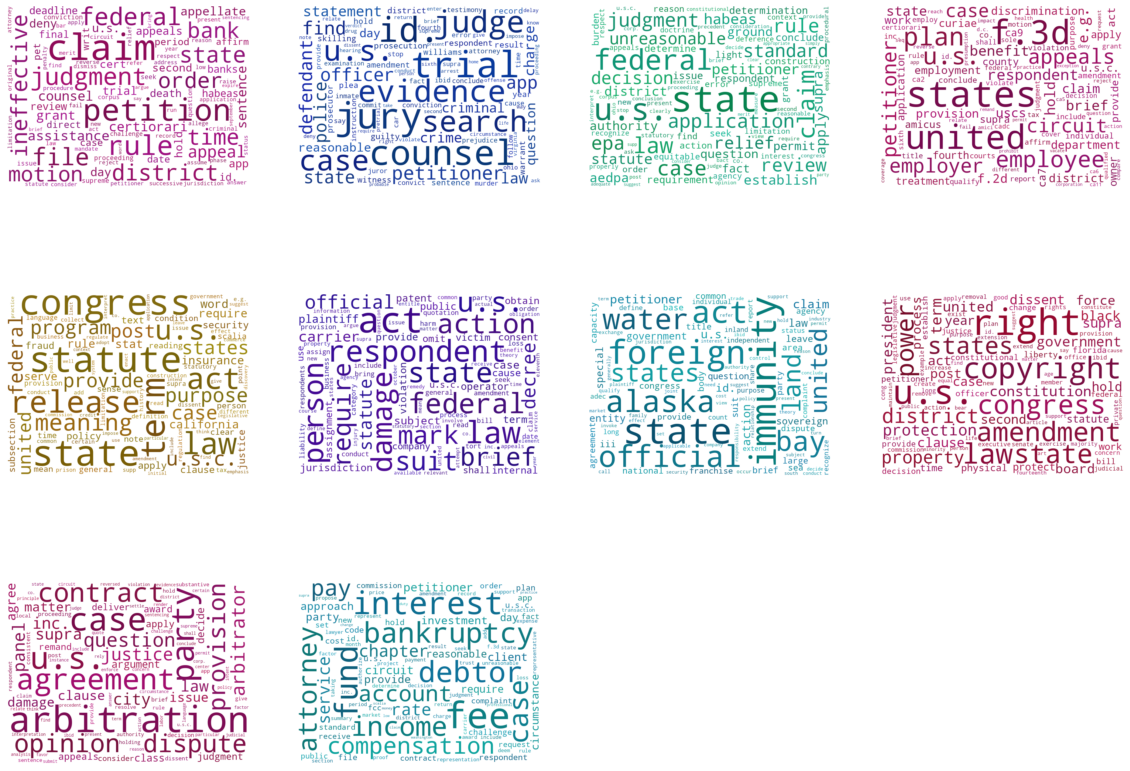

In [54]:
###
# LDA Word Clouds
###

from numpy.random import randint
from wordcloud import WordCloud

plt.rcParams['figure.figsize'] = [20, 15]
# make word clouds for the topics
for i,weights in lda.show_topics(num_topics=-1,
                                 num_words=100,
                                 formatted=False):
    
    #logweights = [w[0], np.log(w[1]) for w in weights]
    maincol = randint(0,360)
    def colorfunc(word=None, font_size=None, 
                  position=None, orientation=None, 
                  font_path=None, random_state=None):   
        color = randint(maincol-10, maincol+10)
        if color < 0:
            color = 360 + color
        return "hsl(%d, %d%%, %d%%)" % (color,randint(65, 75)+font_size / 7, randint(35, 45)-font_size / 10)   

    
    wordcloud = WordCloud(background_color="white", 
                          ranks_only=False, 
                          max_font_size=120,
                          color_func=colorfunc,
                          height=600,width=800).generate_from_frequencies(dict(weights))

    plt.subplot(3, 4, i+1)
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    

In [55]:
# pyLDAvis, for more details, refer to https://github.com/bmabey/pyLDAvis
#!pip install pyLDAvis
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
gensimvis.prepare(lda, doc_term_matrix, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.094852  0.021842       1        1  14.451603
7     -0.087358 -0.052427       2        1  13.851656
4     -0.107356 -0.059600       3        1  12.948866
5     -0.075750  0.010100       4        1  10.996654
2      0.073719 -0.043310       5        1  10.309782
3     -0.035851  0.032438       6        1   8.337749
8      0.028415 -0.165700       7        1   7.784877
9      0.013799  0.107256       8        1   7.552452
0      0.233246  0.042792       9        1   6.921061
6     -0.137715  0.106611      10        1   6.845299, topic_info=            Term         Freq        Total Category  logprob  loglift
139       states  1397.000000  1397.000000  Default  30.0000  30.0000
203  arbitration   440.000000   440.000000  Default  29.0000  29.0000
116         f.3d   782.000000   782.000000  Default  28.0000  28.0000
11         claim  1314.000000  1314.000000  Default  27.0000  27.0000
257       united  1211.000000  1211.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
414         suit    71.514225   332.237063  Topic10  -5.0730   1.1457
33        common    66.081276   265.696993  Topic10  -5.1520   1.2901
108        brief    73.830571   683.465037  Topic10  -5.0411   0.4562
229     question    72.934795   780.717940  Topic10  -5.0533   0.3110
12      congress    62.471156   901.077040  Topic10  -5.2082   0.0127

[555 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
332       1  0.061730  account
332       2  0.117848  account
332       3  0.011224  account
332       4  0.011224  account
332       5  0.056118  account
...     ...       ...      ...
431       2  0.017693    young
431       3  0.053080    young
431       4  0.566189    young
431       5  0.017693    young
431       6  0.318481    young

[2770 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 8, 5, 6, 3, 4, 9, 10, 1, 7])

Using Mallet to calculate coherence scores for different number of topics to automatically determine the best number of topics. Alternatively, you can use LdaMulticore.

In [ ]:
# you need gensim version <= 3.8.3 for this to work
import gensim
from gensim.corpora import Dictionary
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

mallet_path = '~/mallet-2.0.8/bin/mallet'
scores = []
for num_topics in range(2, 20, 2):
    print (num_topics)
    lda = LdaMallet(mallet_path, doc_term_matrix, num_topics=num_topics, id2word=dictionary)
    coherence = CoherenceModel(model=lda, texts=doc_clean, corpus=doc_term_matrix, dictionary=dictionary, coherence='c_v')
    scores.append((num_topics, coherence.get_coherence()))
pd.DataFrame(scores, columns=["Number of Topics", "Coherence Scores"])

opt_topic = max(scores, key=lambda x:x[1])[0]
print(opt_topic)

## Singular Value Decomposition (SVD)

For further reference for this and the following section see [here](https://github.com/fastai/course-nlp/blob/219d0c217bd83339e21471d31cd787e86d6ec0a0/2-svd-nmf-topic-modeling.ipynb).

In [28]:
from scipy import linalg

X = pd.read_pickle('X.pkl').todense()
vec = pd.read_pickle('vec-3grams-1.pkl')
vocab = np.array(vec.get_feature_names())
vocab[400:500]


array(['department', 'described', 'designed', 'despite', 'detention',
       'determination', 'determine', 'determined', 'determining',
       'different', 'difficult', 'direct', 'directly', 'discharge',
       'discretion', 'discrimination', 'dismissed', 'dispute', 'dissent',
       'dissenting', 'distinction', 'district', 'district court',
       'districts', 'doctrine', 'domestic', 'doubt', 'drug', 'drugs',
       'duty', 'earlier', 'ed supp', 'education', 'effect', 'effective',
       'election', 'element', 'elements', 'emphasis', 'emphasis added',
       'employee', 'employees', 'employer', 'employment', 'enacted',
       'end', 'enforce', 'enforcement', 'entered', 'entitled', 'epa',
       'equal', 'equitable', 'erisa', 'error', 'establish', 'established',
       'et', 'et seq', 'event', 'evidence', 'ex', 'example', 'exception',
       'executive', 'exercise', 'existing', 'explained', 'express',
       'expressly', 'extent', 'fact', 'factor', 'factors', 'facts',
       'factual',

In [29]:
U, s, Vh = linalg.svd(X, full_matrices=False)
print(U.shape, s.shape, Vh.shape)

(768, 768) (768,) (768, 1000)


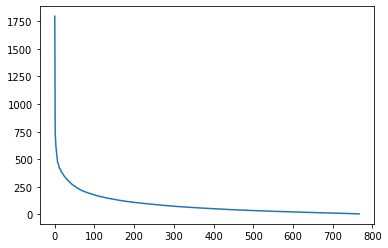

In [30]:
plt.plot(s)

In [31]:
num_top_words=8

def show_topics(a):
    top_words = lambda t: [vocab[i] for i in np.argsort(t)[:-num_top_words-1:-1]]
    topic_words = ([top_words(t) for t in a])
    return [' '.join(t) for t in topic_words]

show_topics(Vh[:10])

['924 debtor securities trust fourth amendment equitable summary judgment waiver',
 'state trial evidence jury counsel defendant death sentence',
 'state state law commerce pre property state court immunity districts',
 'district district court jurisdiction claims claim rule courts habeas',
 'district right amendment school rights minority speech districts',
 'right military jurisdiction habeas war courts rights amendment',
 'rule right tax claim action party arbitration property',
 'school government public tax religious schools program commission',
 'commission tax rate party military judge war plan',
 'counsel rate service evidence right cost act epa']

## Non-negative Matrix Factorization (NMF) 

In [32]:
from sklearn import decomposition

clf = decomposition.NMF(n_components=10, random_state=1)

W1 = clf.fit_transform(X)
H1 = clf.components_

show_topics(H1)

/usr/local/lib/python3.8/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  kwargs['lwork'] = ret[-2][0].real.astype(numpy.int)
/usr/local/lib/python3.8/dist-packages/scipy/linalg/decomp_qr.py:20: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, ch

['act congress statute agency authority regulations use health',
 'trial evidence counsel rule defendant petitioner judge jury',
 'state new state court courts state law tax claim clause',
 'district minority districts plan district court voting majority political',
 'right amendment rights bear second state constitutional clause',
 'military war habeas commission government jurisdiction courts cases',
 'death sentence penalty jury sentencing death penalty crime offense',
 'school public government religious speech schools program private',
 'rate service cost rates commission elements local market',
 'action claims claim jurisdiction rule parties district district court']

## Author Topic Model

In [4]:
from gensim.models import AuthorTopicModel
from gensim.test.utils import temporary_file

df = df.reset_index()
df['id'] = df.index
author2doc = df[:100][['authorship','id']]
author2doc = author2doc.groupby('authorship').apply(lambda x: list(x['id'])).to_dict()
author2doc

{'ALITO': [14, 29, 30, 33, 39, 43],
 'BREYER': [6, 10, 15, 19, 26, 36, 54, 73, 74, 80, 81, 95],
 'GINSBURG': [0, 7, 9, 11, 18, 25, 27, 52, 68, 84, 86, 90, 96, 97],
 'KENNEDY': [3, 4, 16, 21, 34, 40, 42, 48, 62, 64, 65, 76, 85, 87],
 "O'CONNOR": [2, 49, 59, 66, 75, 83, 88],
 'REHNQUIST': [55, 56, 70, 79, 94],
 'ROBERTS': [12, 35, 44],
 'SCALIA': [20, 23, 28, 37, 41, 45, 51, 61, 63, 82, 98],
 'SOUTER': [5, 47, 53, 67, 72, 78, 91, 92],
 'STEVENS': [1, 17, 31, 32, 38, 46, 57, 60, 71, 93],
 'THOMAS': [8, 13, 22, 24, 50, 58, 69, 77, 89, 99]}

In [34]:
model = AuthorTopicModel(
        doc_term_matrix, author2doc=author2doc, id2word=dictionary, num_topics=10)

# For each author list topic distribution
author_vecs = [model.get_author_topics(author) for author in model.id2author.values()]
author_vecs[:2]

[[(0, 0.10000000000000002),
  (1, 0.10000000000000002),
  (2, 0.10000000000000002),
  (3, 0.10000000000000002),
  (4, 0.10000000000000002),
  (5, 0.10000000000000002),
  (6, 0.10000000000000002),
  (7, 0.10000000000000002),
  (8, 0.10000000000000002),
  (9, 0.10000000000000002)],
 [(0, 0.10000000000000002),
  (1, 0.10000000000000002),
  (2, 0.10000000000000002),
  (3, 0.10000000000000002),
  (4, 0.10000000000000002),
  (5, 0.10000000000000002),
  (6, 0.10000000000000002),
  (7, 0.10000000000000002),
  (8, 0.10000000000000002),
  (9, 0.10000000000000002)]]